# Sentiment Analysis of Tweets related to Vaccine
Sentiment Analysis: The process of computationally identifying and categorising opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral (Lexico Dictionary, Oxford University Press)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from emoji import demojize
from itertools import chain
from collections import Counter
from nltk.stem import PorterStemmer
from composition import to_replace

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# Part 1
## Collect the tweets

In [3]:
loc = './tweets.xlsx'
#loc = './old_tweets.xlsx'

In [4]:
try:
    df = pd.read_excel(loc, sheet_name='Sheet1')
except FileNotFoundError:
    print("EXCEL FILE NOT FOUND")

In [5]:
print("Column headings:")
print(df.columns)

Column headings:
Index(['Tweets', 'Positive', 'Negative', 'Neutral'], dtype='object')


In [6]:
df.head()

,Tweets,Positive,Negative,Neutral
0,i literally cannot wait stand in line for my C...,1.0,0.0,0.0
1,@BiomimicAlexis @WashPostPR @JoelAchenbach “Go...,1.0,0.0,0.0
2,China has successfully created a Vaccine for t...,1.0,0.0,0.0
3,Just My Vaccination #InfectiousSongsOrBands @H...,0.0,0.0,1.0
4,@NYGovCuomo Actually there is number on humans...,0.0,0.0,1.0


In [7]:
# Given all the tweets were not labeled, we only pick till they are
labeled_till = (np.where(np.isnan(df['Negative']))[0][0] - 1)
print(labeled_till+1)

312


In [8]:
df = df.loc[0:labeled_till, :]

Tweets   = df["Tweets"]
Positive = df["Positive"]
Negative = df["Negative"]
Neutral  = df["Neutral"]

In [9]:
print("Negative" , Negative.values.sum())
print("Positive" , Positive.values.sum())
print("Neutral " , Neutral.values.sum())
Negative.values.sum() + Positive.values.sum() + Neutral.values.sum()

Negative 41.0
Positive 173.0
Neutral  98.0


312.0

# Part 2 
## Preprocessing


In [10]:
def processTweet(tweets):
    """
    Expects tweets to be a pandas series
    • Lower-casing

    • Normalizing URLs

    • Normalizing Tags and email addresses

    • Normalizing Numbers

    • Normalizing Dollars

    • Word Stemming
    
    • Normalize punctuation 
    
    • Expand Contractions 
    
    • Demojize
    
    • Remove punctuation
    
    (#TODO) Other ideas
    • Negation. Optimization concept.
    • Removal of stop-words and alphanumberic
    """
    
    # Lower case text
    tweets = tweets.str.lower()
    
    # HTML tags
    tweets = tweets.str.replace(r"<[^<>]+>", " ")

    # Account Tag @theFakeDonalDTrump 
    tweets = tweets.str.replace(r"@[^\s]+", 'idaddr')
    
    # Email address
    tweets = tweets.str.replace(r"[^\s]+@[^\s]+", 'emailaddr')
    
    # Handle URLS
    # Look for strings starting with http:// or https://
    tweets = tweets.str.replace(r"(http|https)://[^\s]*", 'httpaddr')
    
    # Handle Numbers
    # Look for one or more characters between 0-9
    tweets = tweets.str.replace(r"[0-9]+", 'number')
    
    # Handle $ sign
    tweets = tweets.str.replace(r"[$]+", 'dollar')
    
    # Normalize punctuation
    transl_table = dict( [ (ord(x), ord(y)) for x,y in zip( u"‘’´“”–-",  u"'''\"\"--") ] ) 
    tweets = tweets.apply(lambda a: a.translate(transl_table))
    
    # Expand Contractions
    tweets = tweets.apply(lambda string: " ".join([to_replace[i] if i in to_replace.keys() else i for i in string.split()]))
    
    # Demojize text
    tweets = tweets.apply(demojize)
    
    # Handle punctuation
    tweets = tweets.str.replace(r"[^\w]+", ' ')
    
    # Stem
    stemmer = PorterStemmer()
    tweets  = tweets.apply(lambda a: list(map(stemmer.stem,a.split())))
    
    return tweets

In [11]:
tweets = processTweet(Tweets)

In [12]:
target   = df.drop('Tweets', axis = 1)

#Reverse one-hot notation  

target   = target.multiply([1,2,3]).values
target   = np.concatenate(target)
target   = target[target!= 0]

In [13]:
X_trainO, X_testO, y_train, y_test = train_test_split(tweets, target, test_size = 0.1, random_state = 42,
                                                    stratify = target)                                     

# Part 3
## Make Feature Vector
Using the corpus, most common words are used to make a feature vector
Each tweet is then converted into a feature vector


###### Concatinating strings in series

In [14]:
allWords = chain.from_iterable(X_trainO) #tweets

In [15]:
words = Counter(allWords)

In [16]:
words.most_common(200)

[('idaddr', 432),
 ('the', 339),
 ('vaccin', 309),
 ('a', 252),
 ('is', 237),
 ('to', 197),
 ('it', 134),
 ('number', 130),
 ('not', 124),
 ('and', 118),
 ('for', 113),
 ('httpaddr', 113),
 ('of', 103),
 ('that', 99),
 ('in', 92),
 ('you', 87),
 ('we', 79),
 ('thi', 78),
 ('be', 73),
 ('ha', 68),
 ('are', 67),
 ('i', 67),
 ('will', 60),
 ('have', 59),
 ('viru', 59),
 ('coronaviru', 55),
 ('there', 52),
 ('do', 48),
 ('but', 46),
 ('if', 44),
 ('they', 44),
 ('with', 43),
 ('or', 41),
 ('on', 38),
 ('peopl', 36),
 ('go', 35),
 ('flu', 35),
 ('get', 34),
 ('as', 34),
 ('can', 33),
 ('mutat', 32),
 ('develop', 31),
 ('amp', 31),
 ('I', 30),
 ('about', 29),
 ('like', 29),
 ('say', 28),
 ('by', 28),
 ('at', 28),
 ('would', 27),
 ('all', 26),
 ('an', 25),
 ('time', 25),
 ('from', 25),
 ('more', 25),
 ('wa', 25),
 ('no', 25),
 ('last', 24),
 ('how', 23),
 ('just', 23),
 ('so', 23),
 ('out', 23),
 ('am', 23),
 ('one', 22),
 ('some', 22),
 ('make', 22),
 ('need', 21),
 ('onli', 21),
 ('test', 2

In [17]:
feature_vector = pd.Series(sorted(words, key=words.get, reverse=True)[:200])

In [18]:
X_train = X_trainO.apply(lambda tweet: feature_vector.isin((tweet)))
X_test  = X_testO.apply(lambda tweet: feature_vector.isin((tweet)))

In [19]:
X_train[:4]

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
35,True,True,True,True,True,True,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
258,False,False,True,True,True,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
54,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
229,False,True,True,True,False,True,False,True,True,True,...,False,False,False,True,False,False,False,False,False,False


#### Export dataset


In [20]:
tmp_featured_tweets = tweets.apply(lambda tweet: feature_vector.isin((tweet)))

In [21]:
tmp_golden_labels = df.drop('Tweets', axis = 1)

In [22]:
pd.concat([tmp_featured_tweets, tmp_golden_labels], axis = 1).to_csv('tweet_sentiment.csv')

# Part 4
**The SVM model**

In [23]:
#Initializing a SVM model 
svm = LinearSVC()

In [24]:
#Fitting the model to the training data

svm.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [25]:
#Extracting the accuracy score from the training data

svm.score(X_train, y_train)

0.9785714285714285

In [26]:
#Extracting the accuracy score from the training data

svm.score(X_test, y_test)

0.59375

In [27]:
actual = y_test
predicted = svm.predict(X_test)
print(classification_report(actual, predicted) )

             precision    recall  f1-score   support

        1.0       0.75      0.67      0.71        18
        2.0       0.50      0.50      0.50         4
        3.0       0.42      0.50      0.45        10

avg / total       0.61      0.59      0.60        32



### Other SVM models
***Linear SVM use one vs rest where as the others use One vs One***

In [28]:
clff = SVC(kernel='linear') #multi_class='crammer_singer'
clff.fit(X_train, y_train)
clff.score(X_test, y_test)

0.59375

In [29]:
clfr = SVC(kernel='poly')
clfr.fit(X_train, y_train)
clfr.score(X_test, y_test)

0.5625

In [30]:
clff = SVC(kernel='rbf')
clff.fit(X_train, y_train)
clff.score(X_test, y_test)

0.5625

**Graphical hyper-parameter optimization**

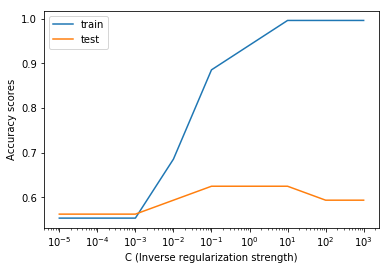

In [31]:
training_scores = []
testing_scores = []

param_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 10, 100, 1000]

# Evaluate the training and test classification errors for each value of the parameter

for param in param_list:
    
    # Create SVM object and fit
    
    svm = LinearSVC(C = param, random_state = 42)
    #svm = SVC(kernel='rbf', C = param, random_state = 42)
    svm.fit(X_train, y_train)
    
    # Evaluate the accuracy scores and append to lists
    
    training_scores.append(svm.score(X_train, y_train) )
    testing_scores.append(svm.score(X_test, y_test) )
    
# Plot results

plt.semilogx(param_list, training_scores, param_list, testing_scores)
plt.legend(("train", "test"))
plt.ylabel('Accuracy scores')
plt.xlabel('C (Inverse regularization strength)')
plt.show()

**Hyper-parameter optimization using GridSearchCV**

In [32]:
#Building the model 

svm = LinearSVC(random_state = 50)

#Using GridSearchCV to search for the best parameter

grid = GridSearchCV(svm, {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 10, 100, 1000]}, cv=10)
grid.fit(X_train, y_train)

# Print out the best parameter

print("The best value of the inverse regularization strength is:", grid.best_params_)
print("The best score of the inverse regularization strength is:", grid.best_score_)

The best value of the inverse regularization strength is: {'C': 1e-05}
The best score of the inverse regularization strength is: 0.5535714285714286


# Part 5
**KNN**

In [33]:
knn_classifier = KNeighborsClassifier(n_neighbors=1)

In [34]:
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [35]:
knn_classifier.score(X_test, y_test)

0.53125

In [36]:
actual = y_test
predicted = knn_classifier.predict(X_test)
print(classification_report(actual, predicted) )

             precision    recall  f1-score   support

        1.0       0.90      0.50      0.64        18
        2.0       0.00      0.00      0.00         4
        3.0       0.40      0.80      0.53        10

avg / total       0.63      0.53      0.53        32



# Part 6
**Naive Bayes model** 

In [37]:
#Initializing an NB classifier

nb_classifier = GaussianNB()

#Fitting the classifier into the training data

nb_classifier.fit(X_train, y_train)

#Extracting the accuracy score from the base classifier

nb_classifier.score(X_test, y_test)

0.5625

In [38]:
actual = y_test
predicted = nb_classifier.predict(X_test)
print(classification_report(actual, predicted) )

             precision    recall  f1-score   support

        1.0       0.92      0.61      0.73        18
        2.0       0.31      1.00      0.47         4
        3.0       0.43      0.30      0.35        10

avg / total       0.69      0.56      0.58        32



**Multinomial NB **

In [39]:
X_trainNB = X_trainO.apply(lambda l: " ".join(l))
X_testNB  = X_testO.apply(lambda l: " ".join(l))

vect = CountVectorizer().fit(X_trainNB)
X_train_vectorized = vect.transform(X_trainNB)

clfrNB = MultinomialNB(alpha = 0.1)
clfrNB.fit(X_train_vectorized, y_train)

clfrNB.score(vect.transform(X_testNB), y_test)

0.5625

In [40]:
actual = y_test
predicted = clfrNB.predict(vect.transform(X_testNB))
print(classification_report(actual, predicted) )

             precision    recall  f1-score   support

        1.0       0.62      0.83      0.71        18
        2.0       0.50      0.50      0.50         4
        3.0       0.25      0.10      0.14        10

avg / total       0.49      0.56      0.51        32



# Other ideas
+ Naïve Bayes Classifier with Sentiment Lexicon: http://www.iaeng.org/IJCS/issues_v46/issue_2/IJCS_46_2_01.pdf
+ Document Retrivial approach. Treat each tweet group as a document i.e. document of positive tweets. Use tf-idf vector model and calculate centroid of all three documents and new tweet and evalute their cosine similarity.

### References
Pandas Excel: https://pythonspot.com/read-excel-with-pandas/

Panda Summary: https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html

Contractions: https://stackoverflow.com/questions/43018030/replace-apostrophe-short-words-in-python

Naive Bayes Summary: https://towardsdatascience.com/algorithms-for-text-classification-part-1-naive-bayes-3ff1d116fdd8

Other articles: 
* https://www.geeksforgeeks.org/multiclass-classification-using-scikit-learn/
* https://www.geeksforgeeks.org/confusion-matrix-machine-learning/
* https://scikit-learn.org/stable/modules/svm.html#svm-kernels